#october

In [1]:
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='ee-haripriyads24')

In [2]:
import ee
import geemap

# Initialize
Map = geemap.Map(center=[25.4358, 81.8463], zoom=11)
aoi = ee.Geometry.Point([81.8463, 25.4358]).buffer(15000)

# 1. Cloud & haze mask
def mask_s2_sr(image):
    scl = image.select('SCL')
    cloud_free = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11))
    return image.updateMask(cloud_free).copyProperties(image, ['system:time_start'])

# 2. Add NDTI band
def add_ndti(image):
    red = image.select('B4')
    green = image.select('B3')
    ndti = red.subtract(green).divide(red.add(green)).rename('NDTI')
    return image.addBands(ndti)

# 3. Add NDWI band
def add_ndwi(image):
    green = image.select('B3')
    nir = image.select('B8')
    ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
    return image.addBands(ndwi)

# 4. Create river mask using NDWI from October 2019
def get_river_mask(start, end):
    collection = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterDate(start, end)
        .filterBounds(aoi)
        .map(mask_s2_sr)
        .map(add_ndwi)
    )
    ndwi_median = collection.select('NDWI').median()
    river_mask = ndwi_median.gt(0.00)
    return river_mask.updateMask(river_mask).clip(aoi)

# Create river mask once (October 2019)
river_mask = get_river_mask('2019-10-01', '2019-10-31')

# 5. Get NDTI median clipped to river only
def get_ndti_composite(start, end):
    collection = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterDate(start, end)
        .filterBounds(aoi)
        .map(mask_s2_sr)
        .map(add_ndti)
    )
    ndti_median = collection.select('NDTI').median()
    return ndti_median.updateMask(river_mask).clip(aoi)

# 6. Visualization
ndti_vis = {'min': -0.5, 'max': 0.5, 'palette': ['green', 'yellow', 'red']}
diff_vis = {'min': -0.2, 'max': 0.2, 'palette': ['blue', 'white', 'red']}
rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
ndwi_vis = {'palette': ['blue']}

# 7. RGB base layer (October 2019)
s2_rgb = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2019-10-01', '2019-10-31')
    .filterBounds(aoi)
    .map(mask_s2_sr)
    .median()
)
Map.addLayer(s2_rgb.clip(aoi), rgb_vis, 'Sentinel-2 RGB (Oct 2019)', True)

# 8. Time periods (October)
periods = {
    '2019': ('2019-10-01', '2019-10-31'),
    '2020': ('2020-10-01', '2020-10-31'),
    '2021': ('2021-10-01', '2021-10-31'),
    '2022': ('2022-10-01', '2022-10-31'),
    '2023': ('2023-10-01', '2023-10-31'),
    '2024': ('2024-10-01', '2024-10-31'),
}

# 9. NDTI per year (masked to river)
ndti_layers = {}
for year, dates in periods.items():
    img = get_ndti_composite(*dates)
    ndti = img.select('NDTI')
    Map.addLayer(ndti, ndti_vis, f'NDTI (River Only) Oct {year}')
    ndti_layers[year] = ndti

# 10. Differences
def add_diff(year1, year2):
    diff = ndti_layers[year2].subtract(ndti_layers[year1])
    Map.addLayer(diff, diff_vis, f'NDTI Change (River Only) Oct {year2} – {year1}')

diff_years = ['2019', '2020', '2021', '2022', '2023', '2024']
for i in range(len(diff_years) - 1):
    add_diff(diff_years[i], diff_years[i + 1])

# 11. Optional pollution points
pollution_points = {
    "Rasoolabad Drain": {'coords': [81.8674, 25.4382], 'color': 'red'},
    "Baxhi Bandh Nala (Govindpur)": {'coords': [81.8529, 25.4531], 'color': 'orange'},
}

for name, data in pollution_points.items():
    point = ee.Geometry.Point(data['coords'])
    Map.addLayer(point, {'color': data['color']}, name)

# 12. Add river mask layer (for visualization)
Map.addLayer(river_mask, ndwi_vis, 'River Mask (NDWI Oct 2019)')

# 13. Show map
Map


Map(center=[25.4358, 81.8463], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression

# 1. Extract mean and std from already computed images
year_list = []
mean_list = []
std_list = []

for year, image in ndti_layers.items():
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True),
        geometry=aoi,
        scale=10,
        maxPixels=1e9,
        bestEffort=True
    ).getInfo()

    year_list.append(int(year))
    mean_list.append(stats.get('NDTI_mean', float('nan')))
    std_list.append(stats.get('NDTI_stdDev', float('nan')))

# 2. Create DataFrame
df = pd.DataFrame({
    'Year': year_list,
    'Mean_NDTI': mean_list,
    'StdDev_NDTI': std_list
})

# 3. Compute Z-score for mean NDTI
df['ZScore_Mean'] = zscore(df['Mean_NDTI'])

# 4. Linear Regression: Trend analysis
X = df['Year'].values.reshape(-1, 1)
y = df['Mean_NDTI'].values.reshape(-1, 1)
model = LinearRegression().fit(X, y)

df['Predicted_Trend'] = model.predict(X)

# 5. Print results
print("NDTI Summary with Z-score and Trend:")
print(df.round(4))

# 6. Optional: Show slope of trend line
slope = model.coef_[0][0]
print(f"\n📈 Linear Trend Slope = {slope:.4f} (per year)")


NDTI Summary with Z-score and Trend:
   Year  Mean_NDTI  StdDev_NDTI  ZScore_Mean  Predicted_Trend
0  2019    -0.0050       0.0456       0.6659          -0.0238
1  2020    -0.0650       0.0945      -1.6065          -0.0233
2  2021    -0.0198       0.0684       0.1042          -0.0228
3  2022     0.0189       0.0636       1.5725          -0.0223
4  2023    -0.0411       0.1199      -0.7005          -0.0218
5  2024    -0.0235       0.0683      -0.0357          -0.0213

📈 Linear Trend Slope = 0.0005 (per year)


In [4]:
import pandas as pd

# Create a list to store results
compound_results = []

# Use same year pairs as in Cell 1
for i in range(len(diff_years) - 1):
    year1 = diff_years[i]
    year2 = diff_years[i + 1]
    label = f"{year2}-{year1}"

    # Get the difference image
    diff_img = ndti_layers[year2].subtract(ndti_layers[year1])

    # Reduce to mean & std over river mask area
    stats = diff_img.reduceRegion(
        reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True),
        geometry=aoi,
        scale=10,
        maxPixels=1e9,
        bestEffort=True
    ).getInfo()

    compound_results.append({
        'Period': label,
        'Mean_∆NDTI': stats.get('NDTI_mean'),
        'StdDev_∆NDTI': stats.get('NDTI_stdDev')
    })

# Convert to DataFrame
compound_df = pd.DataFrame(compound_results)

# Display rounded results
print("📊 Compound ∆NDTI Summary Table:")
print(compound_df.round(4))

📊 Compound ∆NDTI Summary Table:
      Period  Mean_∆NDTI  StdDev_∆NDTI
0  2020-2019     -0.0600        0.1045
1  2021-2020      0.0452        0.1025
2  2022-2021      0.0388        0.0521
3  2023-2022     -0.0600        0.1249
4  2024-2023      0.0175        0.0838


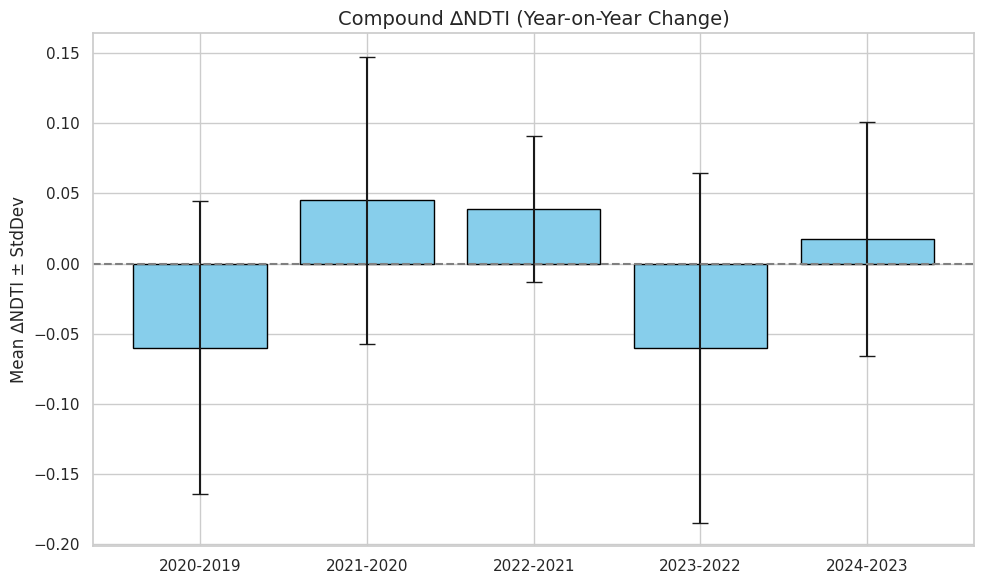

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Updated data from your new summary
data = {
    'Period': ['2020-2019', '2021-2020', '2022-2021', '2023-2022', '2024-2023'],
    'Mean_∆NDTI': [-0.0600, 0.0452, 0.0388, -0.0600, 0.0175],
    'StdDev_∆NDTI': [0.1045, 0.1025, 0.0521, 0.1249, 0.0838]
}

df = pd.DataFrame(data)

# Plot style
sns.set(style="whitegrid")

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(df['Period'], df['Mean_∆NDTI'], yerr=df['StdDev_∆NDTI'],
               capsize=6, color='skyblue', edgecolor='black')

# Add horizontal line at y=0
plt.axhline(0, color='gray', linestyle='--')

# Axis labels and title
plt.title('Compound ∆NDTI (Year-on-Year Change)', fontsize=14)
plt.xlabel('')
plt.ylabel('Mean ∆NDTI ± StdDev')
plt.xticks(rotation=0)  # Keep labels horizontal

# Layout and display
plt.tight_layout()
plt.show()


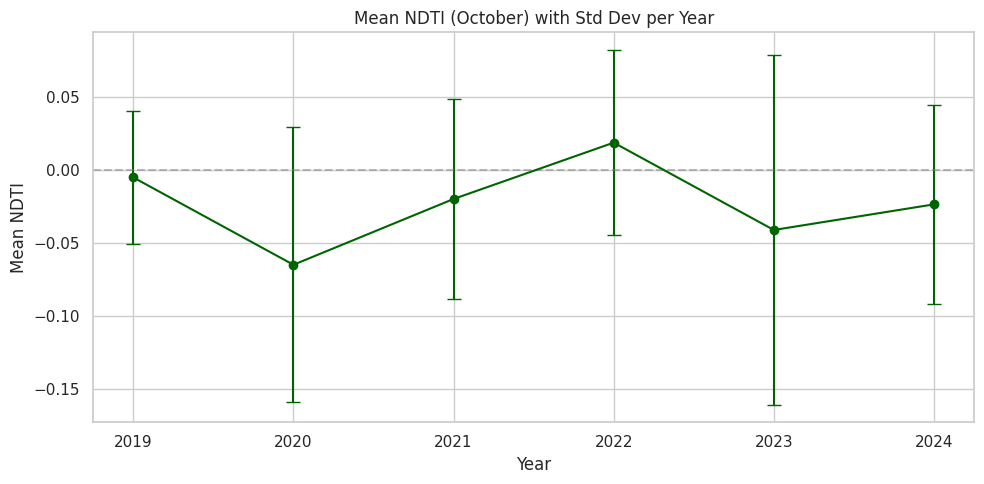

In [6]:
# Cell 1: Mean NDTI with Std Dev Error Bars for October
import pandas as pd
import matplotlib.pyplot as plt

df_oct = pd.DataFrame({
    "Year": [2019, 2020, 2021, 2022, 2023, 2024],
    "Mean_NDTI": [-0.0050, -0.0650, -0.0198, 0.0189, -0.0411, -0.0235],
    "StdDev_NDTI": [0.0456, 0.0945, 0.0684, 0.0636, 0.1199, 0.0683]
})

plt.figure(figsize=(10, 5))
plt.errorbar(df_oct["Year"], df_oct["Mean_NDTI"], yerr=df_oct["StdDev_NDTI"],
             fmt='o-', capsize=5, color='darkgreen')
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.title("Mean NDTI (October) with Std Dev per Year")
plt.xlabel("Year")
plt.ylabel("Mean NDTI")
plt.grid(True)
plt.tight_layout()
plt.show()


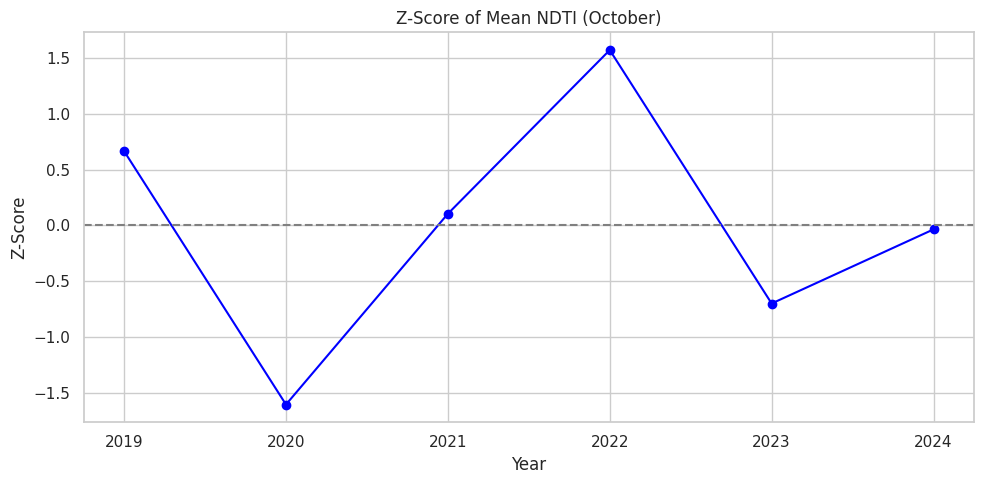

In [7]:
# Cell 2: Z-Score Over Time for October
df_oct["ZScore_Mean"] = [0.6659, -1.6065, 0.1042, 1.5725, -0.7005, -0.0357]

plt.figure(figsize=(10, 5))
plt.plot(df_oct["Year"], df_oct["ZScore_Mean"], marker='o', linestyle='-', color='blue')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Z-Score of Mean NDTI (October)")
plt.xlabel("Year")
plt.ylabel("Z-Score")
plt.grid(True)
plt.tight_layout()
plt.show()


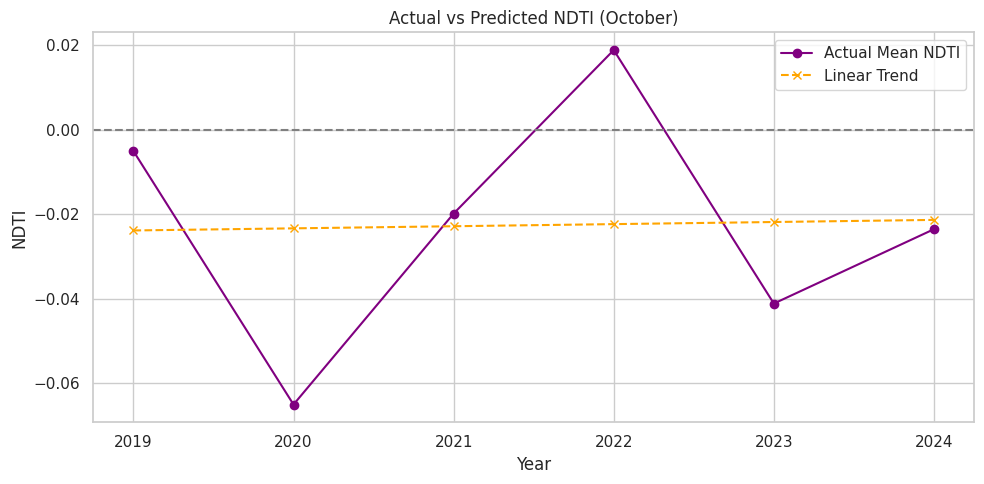

In [8]:
# Cell 3: Actual vs Predicted Trend for October
df_oct["Predicted_Trend"] = [-0.0238, -0.0233, -0.0228, -0.0223, -0.0218, -0.0213]

plt.figure(figsize=(10, 5))
plt.plot(df_oct["Year"], df_oct["Mean_NDTI"], label="Actual Mean NDTI", marker='o', color='purple')
plt.plot(df_oct["Year"], df_oct["Predicted_Trend"], label="Linear Trend", linestyle='--', marker='x', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Actual vs Predicted NDTI (October)")
plt.xlabel("Year")
plt.ylabel("NDTI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


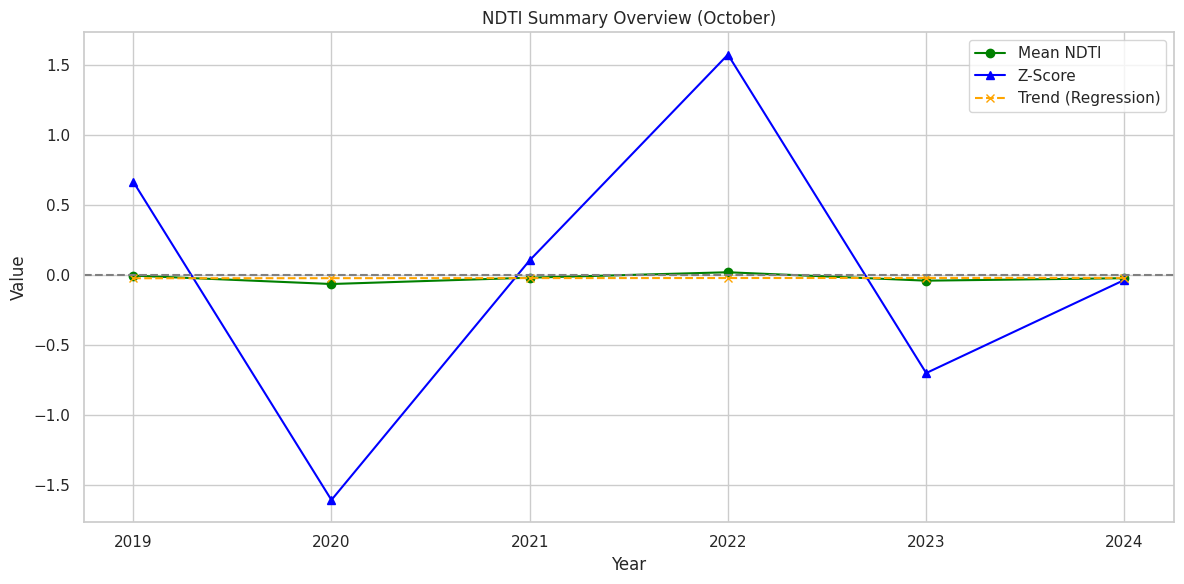

In [9]:
# Cell 4: Combined Multi-Line Overview for October
plt.figure(figsize=(12, 6))
plt.plot(df_oct["Year"], df_oct["Mean_NDTI"], label="Mean NDTI", marker='o', color='green')
plt.plot(df_oct["Year"], df_oct["ZScore_Mean"], label="Z-Score", marker='^', color='blue')
plt.plot(df_oct["Year"], df_oct["Predicted_Trend"], label="Trend (Regression)", linestyle='--', marker='x', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title("NDTI Summary Overview (October)")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
